In [1]:
import Flux: params
using ReinforcementLearning
using ReinforcementLearningExperiments
using Flux
import Flux.params
using Flux.Losses
using IntervalSets
using StableRNGs
using Flux.Optimise
using Flux: crossentropy, ADAM
using LinearAlgebra, Plots
using DifferentialEquations
import Base.rand
import Random: Sampler, SamplerSimple, Repetition, eltype
import Random: seed!
using ControlSystems, FurutaPendulums
using BSON

[ Info: Precompiling FurutaPendulums [8f95568d-7bec-4a61-b2a3-e2d98ddd1432]


In [2]:
furuta = FurutaPendulum()

LoadError: could not load library "libmoberg"
The specified module could not be found. 

In [3]:
mutable struct FurutaEnv <: AbstractEnv
    state
    reward::AbstractFloat
    action_space
    action::AbstractFloat
    state_space
    done
    furuta
    t
    dt
    tmax
end

function FurutaEnv(;
        max_u=5.,
        max_dθ=Inf,
        max_dϕ=Inf,
        dt = 0.005,
        tmax = 10.
        )
    high = [Inf,max_dθ,pi,max_dϕ]
    low = [-Inf,-max_dθ,-pi,-max_dϕ]
    furuta = FurutaPendulum()
    FurutaEnv(
        measured(furuta),
        0.,
        ClosedInterval.(-max_u,max_u),
        0.,
        Space(ClosedInterval{Float64}.(low, high)),
        false,
        furuta,
        0.,
        dt,
        tmax
        )
end

RLBase.action_space(env::FurutaEnv) = env.action_space
RLBase.state_space(env::FurutaEnv) = env.state_space
function RLBase.reward(env::FurutaEnv)
    θ, θdot, ϕ, ϕdot = measured(furuta)
    # env.reward = - θ*ifelse(abs(θ) < π/2, 1.3, 1) - θdot*ifelse(θ < π/2, 0.1, 1)
    env.reward =+ - ifelse(abs(θ) < 1, abs(θ)*5, abs(θ)^2*10) - abs(ϕ)^2/2 - abs(ϕdot)^2/2
end
RLBase.is_terminated(env::FurutaEnv) = env.done
RLBase.state(env::FurutaEnv) = env.state

function (env::FurutaEnv)(a::AbstractFloat)
    # @assert a in env.action_space
    env.action = a
    dt = env.dt
    control(env.furuta,a)
    periodic_wait(env.furuta,env.t,dt)
    furuta = env.furuta
    env.state[:] = measured(furuta)
    env.t += dt
    env.done = env.t >= env.tmax
    nothing
end

function RLBase.reset!(env::FurutaEnv)
    env.action = 0.
    env.reward = 0.
    env.t = 0.
    env.furuta = FurutaPendulum()
    env.state = measured(furuta)
    env.done = false
end

function measured(env)
    x = measure(env)
    x[3] = rem2pi(x[3], RoundNearest)
    return x
end

measured (generic function with 1 method)

In [26]:
run(
#            RandomPolicy(),
           test,
           FurutaEnv(),
           StopAfterEpisode(10),
           TotalRewardPerEpisode()
       )

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29


               ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
               ┌────────────────────────────────────────┐ 
         -3000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠘⢄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠱⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡄⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡸⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⢸⢣⠀⠀⠀⠀⠀⠀⠀⢸│ 
               │⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⡇⠸⡀⠀⠀⠀⠀⠀⠀⡎│ 
               │⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⢸⠀⠀⢇⠀⠀⠀⠀⠀⢰⠁│ 
               │⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡎⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⡎⠀⠀⢸⠀⠀⠀⠀⠀⡜⠀│ 
   Score       │⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢠⠃⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⢰⠁⠀⠀⠀⡇⠀⠀⠀⢠⠃⠀│ 
               │⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡜⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⡎⠀⠀⠀⠀⢱⠀⠀⠀⡸⠀⠀│ 
               │⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⠀⠀⢀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⢰⠁⠀⠀⠀⠀⠈⡆⠀⢀⠇⠀⠀│ 
               │⠀⠀⠀⢱⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⡎⠀⠀⠀⠀⠀⠀⢣⠀⢸⠀⠀⠀│ 
               │⠀⠀⠀⠈⡆⠀⠀⠀⠀⠀⠀⠀⡠⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣧⠃⠀⠀⠀⠀⠀⠀⠸⡀⡇⠀⠀⠀│ 
               │⠀⠀⠀⠀⠈⠢⢄⠀⠀⠀⡠⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⢿⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠑⠢⠊⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀│ 
         -6000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

TotalRewardPerEpisode([-3661.66735981476, -5397.014570525789, -5719.739453877392, -5262.333670039109, -3147.770872785252, -3701.330422788104, -5421.251692714926, -3542.2509943955406, -5608.4908741097715, -3603.4812129472934], 0.0, true)

# Play Pendulum with TD3


Progress: 100%|█████████████████████████████████████████| Time: 0:07:14


                 ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
                 ┌────────────────────────────────────────┐ 
               0 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⠀⢀⡆⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
                 │⠀⡰⡸⡇⠀⠀⠀⠀⠀⢠⢻⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀│ 
                 │⠀⡇⠀⢣⠀⠀⠀⠀⠀⢸⠀⠧⡄⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡀⠀⠀⠀⠀⠀⠀⡟⡄⠀⠀⠀⠀│ 
   Score         │⠀⡇⠀⢸⢀⠀⠀⠀⠀⡇⠀⠀⠱⢤⠀⠀⠀⠀⠀⠀⢸⡄⠀⠀⠀⠀⢀⡇⠀⠀⠀⠀⠀⢰⠁⢱⠀⠀⠀⠀│ 
                 │⢰⠁⠀⢸⡜⢆⠀⠀⠀⡇⠀⠀⠀⢸⠀⡀⠀⠀⠀⠀⡸⢇⠀⡀⠀⠀⢸⢣⠀⠀⠀⠀⠀⢸⠀⠀⠙⢲⠀⠀│ 
                 │⠈⠀⠀⠸⡇⢸⠀⢠⣤⠃⠀⠀⠀⢸⠀⡇⢠⠀⢀⡆⡇⢸⢠⢇⠀⠀⡎⢸⠀⠀⠀⠀⠀⡇⠀⠀⠀⢸⠀⠀│ 
                 │⠀⠀⠀⠀⠀⢸⠀⢸⠘⠀⠀⠀⠀⠸⣰⢱⡸⢣⢸⢱⡇⠀⡿⢸⢀⠎⠀⢸⡞⡄⡀⠀⢰⠁⠀⠀⠀⠘⡄⠀│ 
                 │⠀⠀⠀⠀⠀⠸⡀⡸⠀⠀⠀⠀⠀⠀⣿⢸⡇⠀⠁⠘⠇⠀⠀⠀⠉⠀⠀⠀⠀⠑⠙⠤⠇⠀⠀⠀⠀⠀⡇⠀│ 
                 │⠀⠀⠀⠀⠀⠀⡇⡇⠀⠀⠀⠀⠀⠀⣿⠈⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠗⠒│ 
                 │⠀⠀⠀⠀⠀⠀⣧⠃⠀⠀⠀⠀⠀⠀⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -300000 │⠀⠀⠀⠀⠀⠀

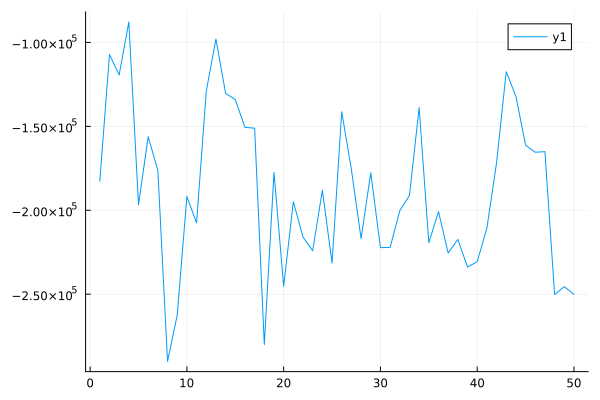

In [146]:
function RL.Experiment(
    ::Val{:JuliaRL},
    ::Val{:TD3},
    ::Val{:Pendulum},
    ::Nothing;
    seed = 123,
)
    rng = StableRNG(seed)
    inner_env = FurutaEnv()
    A = action_space(inner_env)
    low = A.left
    high = A.right
    ns = length(state(inner_env))

    env = ActionTransformedEnv(
        inner_env;
        action_mapping = x -> low + (x + 1) * 0.5 * (high - low),
    )
    init = glorot_uniform(rng)

    create_actor() = Chain(
        Dense(ns, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1, tanh; init = init),
    ) |> cpu

    create_critic_model() = Chain(
        Dense(ns + 1, 30, relu; init = init),
        Dense(30, 30, relu; init = init),
        Dense(30, 1; init = init),
    ) |> cpu

    create_critic() = TD3Critic(create_critic_model(), create_critic_model())

    agent = Agent(
        policy = TD3Policy(
            behavior_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            behavior_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            target_actor = NeuralNetworkApproximator(
                model = create_actor(),
                optimizer = ADAM(),
            ),
            target_critic = NeuralNetworkApproximator(
                model = create_critic(),
                optimizer = ADAM(),
            ),
            γ = 0.99f0,
            ρ = 0.99f0,
            batch_size = 64,
            start_steps = 1000,
            start_policy = RandomPolicy(-1.0..1.0; rng = rng),
            update_after = 1000,
            update_freq = 1,
            policy_freq = 2,
            target_act_limit = 1.0,
            target_act_noise = 0.1,
            act_limit = 1.0,
            act_noise = 0.1,
            rng = rng,
        ),
        trajectory = CircularArraySARTTrajectory(
            capacity = 50_000,
            state = Vector{Float32} => (ns,),
            action = Float32 => (),
        ),
    )

    # stop_condition = StopAfterStep(10_000, is_show_progress=!haskey(ENV, "CI"))
    stop_condition = StopAfterEpisode(50; cur = 0, is_show_progress = true)
    hook = TotalRewardPerEpisode()
    Experiment(agent, env, stop_condition, hook, "# Play Pendulum with TD3")
end

ex = E`JuliaRL_TD3_Pendulum`
run(ex)
plot(ex.hook.rewards)

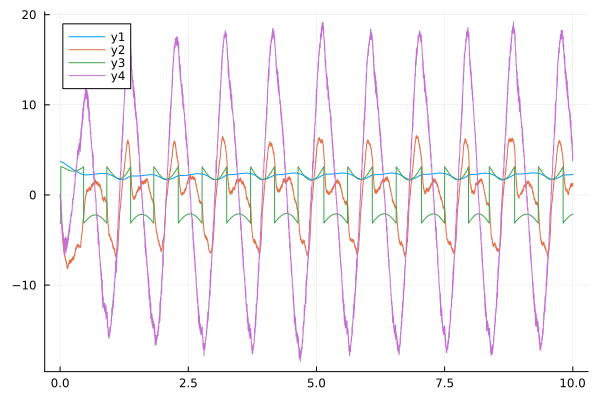

In [149]:
# include("../src/sim/env.jl")

env = FurutaEnv()
dt = 0.002
tmax = 10.
tspan = 0.:dt:tmax
xs = zeros(length(tspan),4)
for (i,t) in enumerate(tspan)
    xs[i,:] = env.state
    u = test(env)
    env(u)
end
plot(tspan,xs)
# animate_pendulum(xs[:,1],xs[:,3],tmax)

In [148]:
# You need to create the ex object first (I did that by training the model above), then load the policy
test = ex.policy
BSON.@load "policy.bson" test

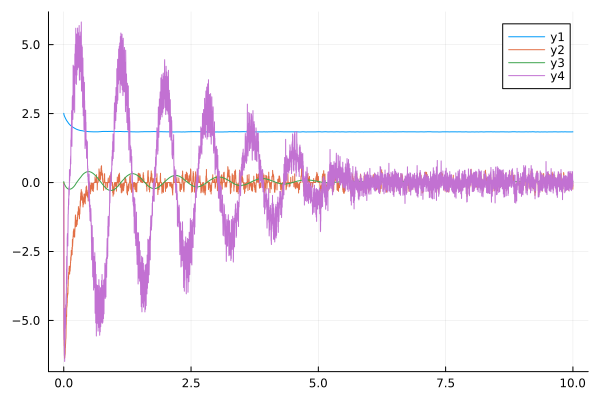

In [47]:
plot(tspan,xs)